# Loadings

In [20]:
#Loading the necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

In [21]:
# Load final dataset
clean_data = pd.read_csv("../clean_training_set_vf.csv")
clean_test = pd.read_csv("../clean_test_set_vf.csv")

# Defining metrics

In this section we are going to define the metrics we will use to evaluate our model. We will use RMSE and Prediction Accuracy.

In [22]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(y_actual, y_predict):
    rmse = sqrt(mean_squared_error(y_actual, y_predict))
    return rmse

In [23]:
# Accuracy
def accuracy(y_actual, y_predict):
    lenght = len(y_actual)
    accuracy_1 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 1) *1) / lenght
    accuracy_2 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 2) *1) / lenght
    accuracy_3 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 3) *1) / lenght
    accuracy_5 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 5) *1) / lenght
    accuracy_10 = sum(((np.abs(y_actual) - np.abs(y_predict)) <= 10) *1) / lenght
    
    return accuracy_1, accuracy_2, accuracy_3, accuracy_5, accuracy_10

# Compute moving average

This section will compute the moving average taxitime given by the average taxitime of the 2 months before each departure. This model is the status quo for computing taxi-out time and will be compared with our Machine learning models.

In [24]:
#Add the variable historical average taxitime per aircraft computed on the training set
clean_test = clean_test.drop(['aircraft_taxitime_x'], axis = 1)
clean_test = clean_test.drop(['aircraft_taxitime_y'], axis = 1)
aircraft = clean_data[['aircraft_model', 'aircraft_taxitime']].groupby("aircraft_model").mean()
clean_test = pd.merge(clean_test,aircraft, on = 'aircraft_model', how='left')

In [25]:
# Fill the missing values
clean_test['aircraft_taxitime'] = clean_test['aircraft_taxitime'].fillna(clean_test['taxitime'].mean())

In [26]:
#Compute the moving average for the training data


clean_data['AOBT'] = pd.to_datetime(clean_data['AOBT'])
moving_avg = clean_data[['AOBT', 'taxitime']]
moving_avg = moving_avg.set_index('AOBT')

#Display each minute within 2015 & 2018
moving_avg = moving_avg.groupby(pd.Grouper(freq = "min")).mean()
moving_avg = moving_avg.reset_index()

#Compute the moving average of taxitime for each row, rolling 2 months before (ie 87840 minutes)
moving_avg['moving_avg'] = moving_avg['taxitime'].rolling(window = 87840, min_periods = 1).mean()

#Shift 1 because the rolling average takes into account the actual  row
moving_avg['moving_avg'] = moving_avg['moving_avg'].shift(1)

#Round the nearest integer
moving_avg['moving_avg'] = moving_avg['moving_avg'].round(0)

# For the first 2 months, replace the values by the global mean
moving_avg['moving_avg'][0:87840] = moving_avg['taxitime'].mean()

moving_avg = moving_avg.dropna()
moving_avg = moving_avg.reset_index()

#Combine the moving_avg table with our clean dataset
df_train = pd.merge(clean_data, moving_avg[['AOBT', 'moving_avg']] ,on = 'AOBT', how='left')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
#Compute the moving average for the test data

clean_test['AOBT'] = pd.to_datetime(clean_test['AOBT'])
moving_avg = clean_test[['AOBT', 'taxitime']]
moving_avg = moving_avg.set_index('AOBT')

#Display each minute within 2015 & 2018
moving_avg = moving_avg.groupby(pd.Grouper(freq = "min")).mean()
moving_avg = moving_avg.reset_index()

#Compute the moving average of taxitime for each row, rolling 2 months before (ie 87840 minutes)
moving_avg['moving_avg'] = moving_avg['taxitime'].rolling(window = 87840, min_periods = 1).mean()

#Shift 1 because the rolling average takes into account the actual  row
moving_avg['moving_avg'] = moving_avg['moving_avg'].shift(1)

#Round the nearest integer
moving_avg['moving_avg'] = moving_avg['moving_avg'].round(0)

# For the first 2 months, replace the values by the global mean
moving_avg['moving_avg'][0:87840] = moving_avg['taxitime'].mean()

moving_avg = moving_avg.dropna()
moving_avg = moving_avg.reset_index()

#Combine the moving_avg table with our clean dataset
df_test = pd.merge(clean_test, moving_avg[['AOBT', 'moving_avg']] ,on = 'AOBT', how='left')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
df_test[['taxitime', 'moving_avg']].describe()

,taxitime,moving_avg
count,135089.000000,135089.000000
mean,19.902338,20.216813
std,8.281781,1.331574
min,0.000000,17.000000
25%,15.000000,19.000000
50%,19.000000,20.000000
75%,23.000000,21.000000
max,284.000000,22.000000


In [29]:
#Print the rmse & accuracy of the moving average
print(rmse(df_test['moving_avg'], df_test['taxitime']))
print(accuracy(df_test['moving_avg'], df_test['taxitime']))

8.221996063350321
(0.5138464271702359, 0.5784926974068947, 0.6425319604112845, 0.7623936812027626, 0.9646973476744961)


# Split the dataset into X & y datasets

In [30]:
#Split the dataset into X & y (where y is the variable to predict)
y_train = df_train['taxitime']
y_test = df_test['taxitime']

X_train = df_train.drop(['taxitime'], axis=1)
X_test = df_test.drop(['taxitime'], axis=1)

# Features importance & selection

We will use several algorithm to display features importance plots.

## Coefficients as Feature Importance

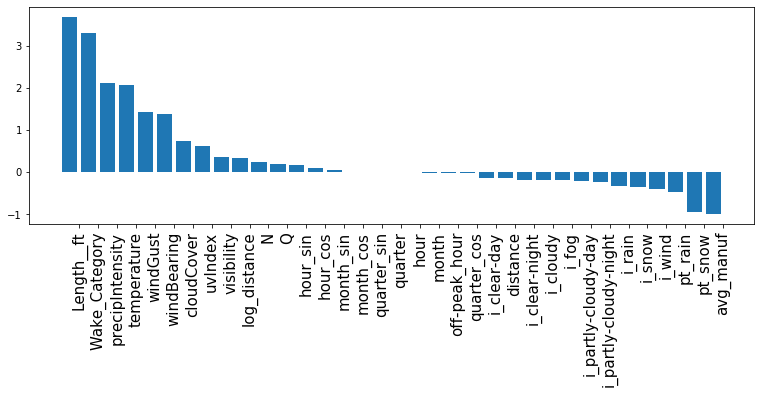

In [182]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

#Define the features
features = ['Length__ft', 'Wake_Category', 
       'precipIntensity','temperature',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'log_distance', 'N', 'Q', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'quarter_sin', 'quarter',
       'hour', 'month', 'off-peak_hour', 
        'quarter_cos', 'i_clear-day', 'distance',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'avg_manuf']
train = X_train[features]
test = X_test[features]

# define the model
model_reg = LinearRegression()
# fit the model
model_reg.fit(train, y_train)
# get importance
ordering = np.argsort(model_reg.coef_)[::-1][:50]
importance = model_reg.coef_[ordering]

x = np.arange(len(features))
fig = plt.figure(figsize=(13,4))
plt.bar(x, importance)
plt.xticks(x + 0.5, features, rotation=90, fontsize=15);



## Random Forest Feature Importance

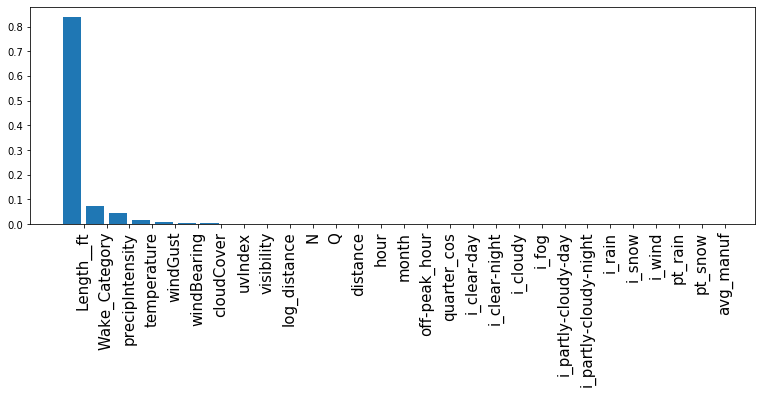

In [186]:
from sklearn.ensemble import RandomForestRegressor

# define the model
model_rf = RandomForestRegressor(
         n_estimators=10, max_depth=10)

# fit the model
model_rf.fit(train, y_train)

# Get importance
ordering = np.argsort(model_rf.feature_importances_)[::-1][:50]

importances = model_rf.feature_importances_[ordering]

x = np.arange(len(features))
fig = plt.figure(figsize=(13,4))
plt.bar(x, importances)
plt.xticks(x + 0.5, features, rotation=90, fontsize=15);

## XGBoost Feature Importance

In [245]:
# Find feature importance using XGboost algorithm
import xgboost as xgb


# Regressor choice with basic parameters
model_features = xgb.XGBRegressor( colsample_bytree=1, 
             importance_type='gain', learning_rate=0.1, max_depth=5, 
            min_child_weight=1, n_estimators=20, objective='reg:squarederror', 
            random_state=0, subsample=1, verbosity=0)


#Fit the model
model_features.fit(train, y_train,
        eval_set=[(train, y_train), (test, y_test)],
        early_stopping_rounds=10,
       verbose=False)

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

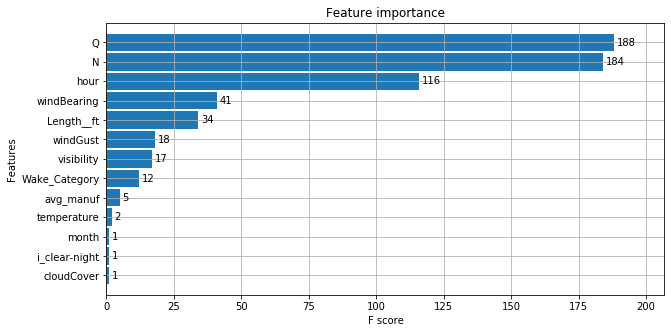

In [193]:
#Plot the features importance of the first 20 most importance features
fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(model_xgb, ax=ax, height=0.9, max_num_features=20)
plt.show()

## Tuning of the number of features

In [ ]:
# Fit model using each importance as a threshold
thresholds = sort(reg_TV.feature_importances_)
for var in (20, 22, 25):
    num = len(thresholds) - var
    thresh = thresholds[num]
    # select features using threshold
    selection = SelectFromModel(model_selection, threshold=thresh, prefit=True)
    select_X_train_TV = selection.transform(X_train_TV)

    test_TV = model_selection.predict(select_X_train_TV)
    rmse1 = math.sqrt(mean_squared_error(y_train_TV, test_TV))

    # evaluate model
    select_X_valid_TV = selection.transform(X_valid_TV)
    y_pred_TV = model_selection.predict(select_X_valid_TV)
    rmse2 = math.sqrt(mean_squared_error(y_valid_TV, y_pred_TV))
    print("Thresh=%.3f, n=%d, rmse train: %.2f, rmse valid: %.2f" % 
          (thresh, select_X_train_TV.shape[1], rmse1, rmse2))
    
    
#Create the final X_train for TV consumption
max_features = 22
thresh = thresholds[len(thresholds) - max_features]
selection = SelectFromModel(model_selection, threshold=thresh, prefit=True)
final_X_train_TV = selection.transform(X_train_TV)
final_X_valid_TV = selection.transform(X_valid_TV)

# Model testing

We tried 3 regresors to model the taxitime: Gradient Boosting, Random Forest & Linear Regression

## Gradient Boosting

In [31]:
from sklearn.ensemble import GradientBoostingRegressor


features = ['Length__ft', 'Wake_Category', 'distance', 
       'precipIntensity', 'temperature', 'windBearing', 'cloudCover', 'visibility',
     'precipAccumulation',  'N', 'Q','hour', 'month', 'quarter', 
            'off-peak_hour', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'aircraft_taxitime', 'moving_avg']

train = X_train[features]
test = X_test[features] 


model_gb = GradientBoostingRegressor(random_state=0, max_depth = 5,  n_estimators=150, 
                                     learning_rate = 0.1, subsample = 0.8, verbose=True)
model_gb.fit(train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          57.0893           9.6539            6.41m
         2          49.7457           7.7559            6.65m
         3          43.6032           6.1463            6.42m
         4          38.5096           5.1451            6.27m
         5          34.4900           4.1401            6.22m
         6          30.8133           3.3968            6.21m
         7          26.9868           2.8040            6.12m
         8          24.6296           2.3062            6.17m
         9          23.7219           1.9231            6.15m
        10          21.2329           1.6001            6.54m
        20          15.3679           0.2799            7.43m
        30          13.9504           0.0696            6.63m
        40          13.5001           0.0483            5.90m
        50          13.1824           0.0154            5.30m
        60          12.8613           0.0134            4.59m
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.8, tol=0.0001, validation_fraction=0.1,
                          verbose=True, warm_start=False)

In [32]:
predict_gb = model_gb.predict(test)
print(rmse(y_test, predict_gb))
print(accuracy(y_test, predict_gb))

3.60745860092196
(0.6094796763615098, 0.7214132904973758, 0.8086520738180014, 0.9149079495739846, 0.9872824582312402)


## Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor

features = ['Length__ft', 'Wake_Category', 'distance', 
       'precipIntensity', 'temperature', 'windBearing', 'cloudCover', 'visibility',
     'precipAccumulation',  'N', 'Q','hour', 'month', 'quarter', 
            'off-peak_hour', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'aircraft_taxitime', 'moving_avg']

train = X_train[features]
test = X_test[features] 

model_rf = RandomForestRegressor(
         n_estimators=20, max_depth=13, max_features = 15)

model_rf.fit(train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features=15, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
predict_rf = model_rf.predict(test)
print(rmse(y_test, predict_rf))
print(accuracy(y_test, predict_rf))

3.7219202399248608
(0.5779745205012992, 0.6931282339790804, 0.7868294235652051, 0.9047368771698658, 0.9857279275144535)


## Linear regression

In [130]:
features = ['Length__ft', 'Wake_Category', 'distance', 
       'precipIntensity', 'temperature', 'windBearing', 'cloudCover', 'visibility',
     'precipAccumulation',  'N', 'Q','hour', 'month', 'quarter', 
            'off-peak_hour', 'i_clear-day',
       'i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day',
       'i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 
       'pt_rain', 'pt_snow', 'aircraft_taxitime', 'moving_avg']

train = X_train[features]
test = X_test[features] 

# define the model
model_reg = LinearRegression()
# fit the model
model_reg.fit(train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [132]:
predict_reg = model_reg.predict(test)
print(rmse(y_test, predict_reg))
print(accuracy(y_test, predict_reg))

3.9773976511633276
(0.5377047724093005, 0.6508375959552591, 0.7502535365573807, 0.8834694164587791, 0.9817157577596992)


# Hyperparameters Tuning

In [60]:
# Example of parameters tuning
rmse_score = make_scorer(rmse, greater_is_better=False )

#Declare the parameters to tune
parameters = {
           'n_estimators':[10, 20],
             'max_depth':[3, 5]
}


#Implement a Grid Search that will run the estimator for each set of parameters
grid_search = GridSearchCV(estimator=model_rf, 
                           param_grid=parameters,
                           scoring = rmse_score,
                           n_jobs = 4,
                           cv = 5,
                           verbose=True
)

grid_search.fit(train, y_train)

print(
    f"The best set of parameters is: {grid_search.best_params_}")

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.2min finished


The best set of parameters is: {'max_depth': 5, 'n_estimators': 20}
Best: -4.230272 using {'max_depth': 5, 'n_estimators': 20}


# Skater model interpretability

In this section we use Skater, a unified framework for Model Interpretation, to demystify the learned structures of our taxi time prediction models both globally (inference on the basis of a complete data set) and locally (inference about an individual taxi time predictions).

In [33]:
#Load the packages
from datetime import datetime, timedelta
from scipy import stats
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [34]:
# Creating an interpretation object 
interpreter = Interpretation(test, feature_names=features)
annotated_model = InMemoryModel(model_gb.predict, examples=train)
print("Input shape: {}".format(annotated_model.input_shape))
print("Model Type: {}".format(annotated_model.model_type))

Input shape: (540862, 28)
Model Type: regressor


### Global Iterpretability

[30/30] grid cells ████████████████████ Time elapsed: 3 seconds

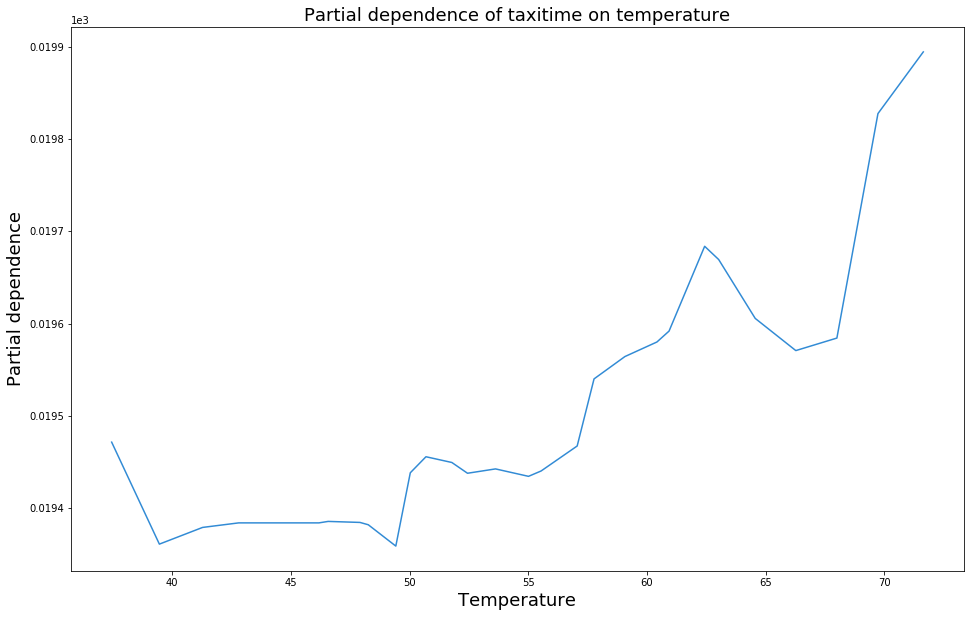

In [37]:
# 1-way partial dependence plots
from matplotlib.pyplot import figure
# from matplotlib.ticker import FormatStrFormatter
pdp_features = ['temperature']
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30
)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Partial dependence', fontsize=18)
plt.title('Partial dependence of taxitime on temperature', fontsize=18)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # 2 decimal places
plt.legend('',frameon=False)


[360/360] grid cells ████████████████████ Time elapsed: 6 seconds

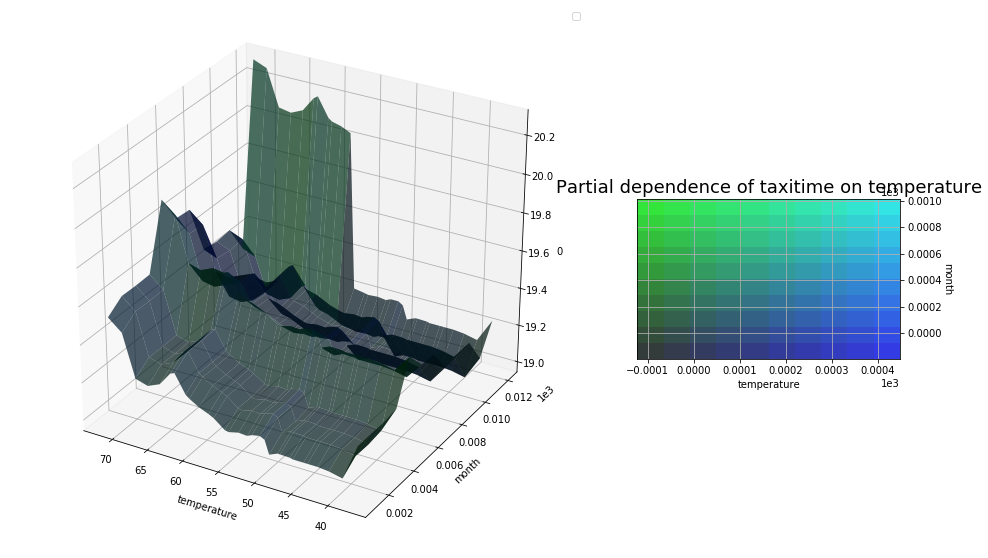

In [40]:
# 2-way partial dependence plots
pdp_features = [('temperature', 'month')]
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30
)
#plt.xlabel('Temperature', fontsize=18)
#plt.ylabel('Month', fontsize=18)
plt.title('Partial dependence of taxitime on temperature', fontsize=18)
plt.legend('',frameon=False)

### Local Interpretability

In [41]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
features = ['Engines','Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft','Wake_Category', 'distance','precipIntensity', 'precipProbability', 'temperature','apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed','windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q','hour', 'month', 'quarter', 'off-peak_hour', 'hour_sin', 'hour_cos','month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'i_clear-day','i_clear-night', 'i_cloudy', 'i_fog', 'i_partly-cloudy-day','i_partly-cloudy-night', 'i_rain', 'i_snow', 'i_wind', 'pt_None','pt_rain', 'pt_snow', 'avg_manuf']
#features = ['Engines','Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 'Wheelbase__ft','Wake_Category', 'distance','precipIntensity', 'precipProbability', 'temperature','apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed','windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'precipAccumulation', 'ozone', 'log_distance', 'N', 'Q','hour', 'month', 'quarter', 'off-peak_hour', 'hour_sin', 'hour_cos','month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'avg_manuf']
exp = LimeTabularExplainer(test.values, feature_names=features, mode='regression', class_names=['High taxi time', 'Low taxi time'])

In [43]:
example_nb = 300
print('Reference:', y_test.iloc[example_nb])
print('Predicted:', predict_gb[example_nb])
exp.explain_instance(test.iloc[example_nb].values, model_gb.predict).show_in_notebook()

Reference: 19.0
Predicted: 17.5294196535418
